<a href="https://colab.research.google.com/github/andreacangiani/NMPDE2025/blob/main/python/CP2_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Divided differences using sparse matrix

Import the usual modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

New module: sparse algebra

In [ ]:
import scipy.sparse as sp

Function implementing the forward difference in sparse format

In [ ]:
def forw_diff(N):
  # Compute FD matrix in spare fom using Compressed Sparse Row (CSR) format
  data=[-np.ones(N+1), np.ones(N)]
  return sp.diags(data,[0,1], format="csr")


In [ ]:
help(sp.diags)

Exmaple of Forward Difference matrix

In [ ]:
# Fix a grid
a=0
b=1
N=5
h=(b-a)/N
D=forw_diff(N)/h


In [ ]:
print(D)

In [ ]:
print(D.todense())

Test: use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$

In [ ]:
# Fix function f using symbolic tool
t = sym.var('t')
fsym = 0.5 * t**2
# Define the function as an inline function
f = sym.lambdify(t, fsym )

# Set up interval and cardinality of the grid
a=0
b=1
N=50
h=(b-a)/N

# set up grid points
x = np.linspace(a,b,N+1)

# Evaluate FD matrix
D=forw_diff(N)/h

# Values of the derivative at the grid points
uh = D.dot(f(x))[1:N]

# Print results
#print(uh)

Compute max error

In [ ]:
fdsym = fsym.diff(t,1)
fd = sym.lambdify(t,fdsym)

print(max(abs(uh-fd(x[1:N]))))

**Exercise 1.** Find a way to evaluate execution time and compare full vs sparse exectution time in function of the grid size N.

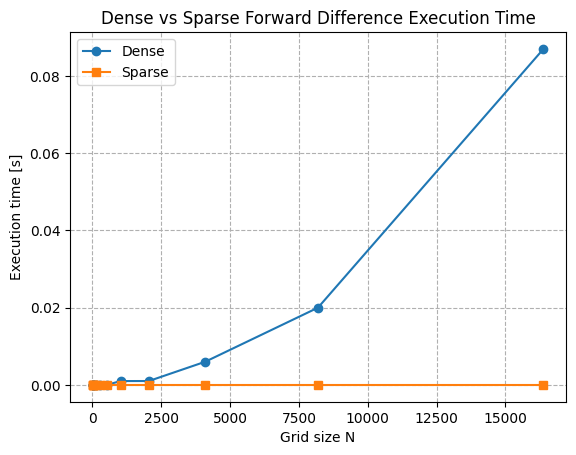

In [93]:
import time

def forw_diff(N):
    data = [-np.ones(N+1), np.ones(N)]
    return sp.diags(data, [0, 1], format="csr")

def forw_diff_dense(N):
    D = np.zeros((N+1, N+1))
    for i in range(N):
        D[i, i] = -1
        D[i, i+1] = 1
    return D

t = sym.var('t')
fsym = 0.5 * t**2
fdsym = fsym.diff(t, 1)
f = sym.lambdify(t, fsym)
fd = sym.lambdify(t, fdsym)

a, b = 0, 1
n_exp = 15
N_values = [2**N for N in range(2, n_exp)]
time_sparse = []
time_dense = []

for N in N_values:
    h = (b - a) / N
    x = np.linspace(a, b, N+1)
    fx = f(x)
    
    D_sparse = forw_diff(N) / h
    start = time.time()
    uh_sparse = D_sparse.dot(fx)[1:N]
    end = time.time()
    time_sparse.append(end - start)
    
    D_dense = forw_diff_dense(N) / h
    start = time.time()
    uh_dense = D_dense.dot(fx)[1:N]
    end = time.time()
    time_dense.append(end - start)

plt.plot(N_values, time_dense, 'o-', label='Dense')
plt.plot(N_values, time_sparse, 's-', label='Sparse')
plt.xlabel('Grid size N')
plt.ylabel('Execution time [s]')
plt.title('Dense vs Sparse Forward Difference Execution Time')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


# Finite Differences for two-points boundary value problems with constant coefficients

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approxima the second derivative.

Given $h>0$,

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Function for second central matrix

In [ ]:
def CD2(N):
  # Function defining nominator of
  # second central FD formula on a
  # uniform grid in sparse CSR format
  data = [np.ones(N), -2*np.ones(N+1), np.ones(N)]
  return sp.diags(data,[-1,0,1], format="csr")


Example of second central matrix.

In [ ]:
N=5
A = CD2(N)

#print(cent_diff)
print(A.todense())

Test problem:

$(a,b)=(0,\pi)$

$u(x)=sin(x)$

In [ ]:
# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Define exact solution
usym = sym.sin(t)
u = sym.lambdify(t, fsym )

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula.

In [ ]:
# Problem domain
a=0
b=np.pi

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N)

# Right-hand side
F=-h**2*f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A = A[1:-1,1:-1]


Import solver

In [ ]:
from scipy.sparse.linalg import spsolve

Solve problem and print result

In [ ]:
# Compute solution at internal nodes
uh = spsolve(A,F)
# plot solution
plt.plot(x[1:-1],uh)

In [ ]:
# print max error

print(np.max(np.abs(uh-u(x[1:-1]))))

**Exercise 2.** test for convergence and plot convergence plot

In [ ]:
n_exp=15

nn=[]
error=[]

for i in range(3,n_exp):
    N=2**i
    h=(b-a)/N
    x=np.linspace(a,b,N+1)
    A=CD2(N)
    F=-h**2*f(x[1:-1])
    A = A[1:-1,1:-1]
    uh = spsolve(A,F)
    nn.append(N)
    error.append(np.max(np.abs(uh-u(x[1:-1]))))

print(nn)
print(f(error))
plt.loglog(nn, error,'o-', label="Error FD")
plt.loglog(nn, [n**(-2) for n in nn],'o-', label="1/N^2")
plt.legend()
plt.grid(True)
plt.show()
    

**Exercise 3.** Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

**Exercise 4.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

**Exercise 5.** Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$
